# Projekt końcowy - część 2 - eksploracyjna analiza danych


1. Wysokopoziomowa analiza cech - ogólny rzut okiem który pozwoli lepiej zrozumieć dane

2. Sprawdzenie korelacji zmiennych (z targetem/między sobą)

3. Odpowiedź na 6 pytań z treści projektu:
    * dobrze dobrana wizualizacja
    * opisanie własnych obserwacji
    * poparcie testem statystycznym (opcjonalnie)
    
4. Dalsza, autorska eksploracja - rozbudowanie części projektu o Wasze pomysły, hipotezy i odkryte wcześniej rzeczy

## Wstępne obejrzenie bazy

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/MyDrive/projekt_koncowy/Loan_data_after_part_1.csv', index_col=0)
df.head()

,loan_amnt,funded_amnt,term,int_rate_in_percent,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,revol_bal,revol_util_in_percent,pub_rec_bankruptcies
1,5000.0,5000.0,36,10.65,162.87,B,B2,10.0,RENT,24000.0,...,27.65,0.0,1985-01-01,735.0,739.0,1.0,3.0,13648.0,83.7,0.0
2,2500.0,2500.0,60,15.27,59.83,C,C4,1.0,RENT,30000.0,...,1.00,0.0,1999-04-01,740.0,744.0,5.0,3.0,1687.0,9.4,0.0
3,2400.0,2400.0,36,15.96,84.33,C,C5,10.0,RENT,12252.0,...,8.72,0.0,2001-11-01,735.0,739.0,2.0,2.0,2956.0,98.5,0.0
4,10000.0,10000.0,36,13.49,339.31,C,C1,10.0,RENT,49200.0,...,20.00,0.0,1996-02-01,690.0,694.0,1.0,10.0,5598.0,21.0,0.0
5,3000.0,3000.0,60,12.69,67.79,B,B5,1.0,RENT,80000.0,...,17.94,0.0,1996-01-01,695.0,699.0,0.0,15.0,27783.0,53.9,0.0


In [ ]:
df.shape

(42370, 26)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42370 entries, 1 to 42479
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_amnt                 42370 non-null  float64
 1   funded_amnt               42370 non-null  float64
 2   term                      42370 non-null  int64  
 3   int_rate_in_percent       42370 non-null  float64
 4   installment               42370 non-null  float64
 5   grade                     42370 non-null  object 
 6   sub_grade                 42370 non-null  object 
 7   emp_length                42370 non-null  float64
 8   home_ownership            42370 non-null  object 
 9   annual_inc                42370 non-null  float64
 10  verification_status       42370 non-null  object 
 11  loan_status               42370 non-null  object 
 12  desc                      42370 non-null  object 
 13  purpose                   42370 non-null  object 
 14  title(

In [ ]:
#zmieniam nazwę kolumny, bo jest w niej literówka, przez co ciągle się mylę
df.rename(columns = {'emp_length': 'emp_lenght'}, inplace = True)

## Zastąpienie typów object typami numerycznymi, tam gdzie się da, m.in w targecie

### Zmiana 'loan status' na kolumnę numeryczną

In [ ]:
df.loan_status.value_counts()

Fully Paid                                             34044
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1925
Does not meet the credit policy. Status:Charged Off      748
Name: loan_status, dtype: int64

In [ ]:
# zgrupowanie targetu do 2 wartości
df.loc[ df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'Fully Paid'
df.loc[ df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'Charged Off'

In [ ]:
# zamiana targetu na int: Fully Paid:1, Charged Off:0
df.loc[df['loan_status'] == 'Charged Off', 'loan_status'] = int(0)
df.loc[df['loan_status'] == 'Fully Paid', 'loan_status'] = int(1) 

In [ ]:
df.loan_status.dtypes

dtype('O')

In [ ]:
df.loan_status = df.loan_status.astype(int)

In [ ]:
df.loan_status.dtypes

dtype('int64')

### Zmiana 'verification_status' na kolumnę numeryczną

In [ ]:
df.verification_status.value_counts()

Not Verified       18616
Verified           13460
Source Verified    10294
Name: verification_status, dtype: int64

In [ ]:
# zamiana na int: Source verified:2, Verified:1, Not verified:0
df.loc[df['verification_status'] == 'Source Verified', 'verification_status'] = int(2)
df.loc[df['verification_status'] == 'Verified', 'verification_status'] = int(1)
df.loc[df['verification_status'] == 'Not Verified', 'verification_status'] = int(0)

In [ ]:
df.verification_status.value_counts()

0    18616
1    13460
2    10294
Name: verification_status, dtype: int64

In [ ]:
df.verification_status.dtypes

dtype('O')

In [ ]:
df.verification_status = df.verification_status.astype(int)

In [ ]:
df.verification_status.dtypes

dtype('int64')

### Zmiana 'grade' na kolumnę numeryczną

Im niższa cyfra tym lepsza ocena (niższe ryzyko, bardziej wiarygodny kredytobiorca).
Skala 1-7

In [ ]:
df.grade.value_counts()

B    12364
A    10152
C     8704
D     5985
E     3370
F     1288
G      507
Name: grade, dtype: int64

In [ ]:
df["grade"].replace({"A": "1", "B": "2","C": "3", "D": "4", "E": "5", "F": "6", "G": "7" }, inplace=True)

In [ ]:
df.grade.value_counts()

2    12364
1    10152
3     8704
4     5985
5     3370
6     1288
7      507
Name: grade, dtype: int64

In [ ]:
df.grade.dtypes

dtype('O')

In [ ]:
df.grade = df.grade.astype(int)

In [ ]:
df.grade.dtypes

dtype('int64')

### Zmiana 'home_ownership' na kolumnę numeryczną

In [ ]:
df.home_ownership.value_counts()

RENT        20093
MORTGAGE    18907
OWN          3234
OTHER         134
NONE            2
Name: home_ownership, dtype: int64

In [ ]:
# OWN - 1, RENT - 2, MORTGAGE - 3, OTHER oraz NONE - 4
df["home_ownership"].replace({"OWN": "1", "RENT": "2","MORTGAGE": "3", "OTHER": "4", "NONE": "4" }, inplace=True)

In [ ]:
df.home_ownership.value_counts()

2    20093
3    18907
1     3234
4      136
Name: home_ownership, dtype: int64

In [ ]:
df.home_ownership.dtypes

dtype('O')

In [ ]:
df.home_ownership = df.home_ownership.astype(int)

In [ ]:
df.home_ownership.dtypes

dtype('int64')

### Zmiana 'desc' na kolumnę numeryczną

In [ ]:
# 0 - jesli pożyczkobiorca nie dał żadnego opisu, 1 - jeśli był opis
def change_value(rec):
    if rec == 'no_desc':
      rec = 0
    else:
       rec = 1
    return rec
      
df['desc'] = df.desc.apply(change_value)

In [ ]:
df.desc.value_counts()

1    29108
0    13262
Name: desc, dtype: int64

### Rzut okiem na zmodyfikowaną bazę

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42370 entries, 1 to 42479
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_amnt                 42370 non-null  float64
 1   funded_amnt               42370 non-null  float64
 2   term                      42370 non-null  int64  
 3   int_rate_in_percent       42370 non-null  float64
 4   installment               42370 non-null  float64
 5   grade                     42370 non-null  int64  
 6   sub_grade                 42370 non-null  object 
 7   emp_lenght                42370 non-null  float64
 8   home_ownership            42370 non-null  int64  
 9   annual_inc                42370 non-null  float64
 10  verification_status       42370 non-null  int64  
 11  loan_status               42370 non-null  int64  
 12  desc                      42370 non-null  int64  
 13  purpose                   42370 non-null  object 
 14  title(

In [ ]:
#df.describe(include='all').T
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,42370.0,11112.623908,7411.801846,500.00,5250.00,9800.00,15000.00,35000.00
funded_amnt,42370.0,10843.875384,7147.489138,500.00,5100.00,9600.00,15000.00,35000.00
term,42370.0,42.229124,10.521388,36.00,36.00,36.00,60.00,60.00
int_rate_in_percent,42370.0,12.164367,3.708500,5.42,9.63,11.99,14.72,24.59
installment,42370.0,323.222484,208.946887,15.67,165.82,278.48,429.18,1305.19
grade,42370.0,2.668374,1.436923,1.00,2.00,2.00,4.00,7.00
emp_lenght,42370.0,5.182464,3.457604,1.00,2.00,4.00,9.00,10.00
home_ownership,42370.0,2.376328,0.627526,1.00,2.00,2.00,3.00,4.00
annual_inc,42370.0,69162.587565,64092.735585,1896.00,40000.00,59000.00,82500.00,6000000.00
verification_status,42370.0,0.803587,0.802346,0.00,0.00,1.00,1.00,2.00


## Analiza poszczególnych cech oraz korelacji pomiędzy nimi oraz pomiędzy nimi a targetem

### Outliersy i korelacje

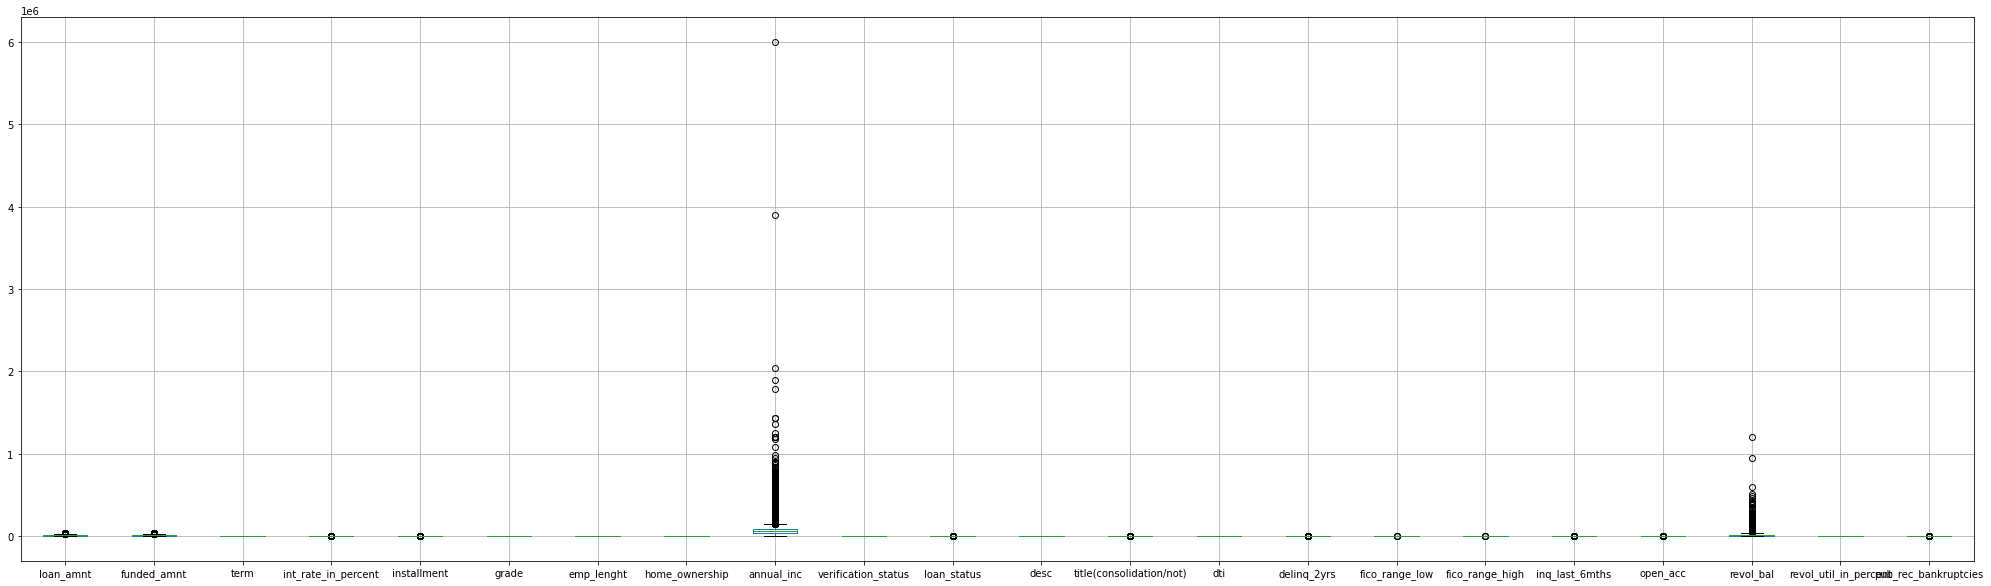

In [ ]:
df.boxplot(figsize=(35,10))

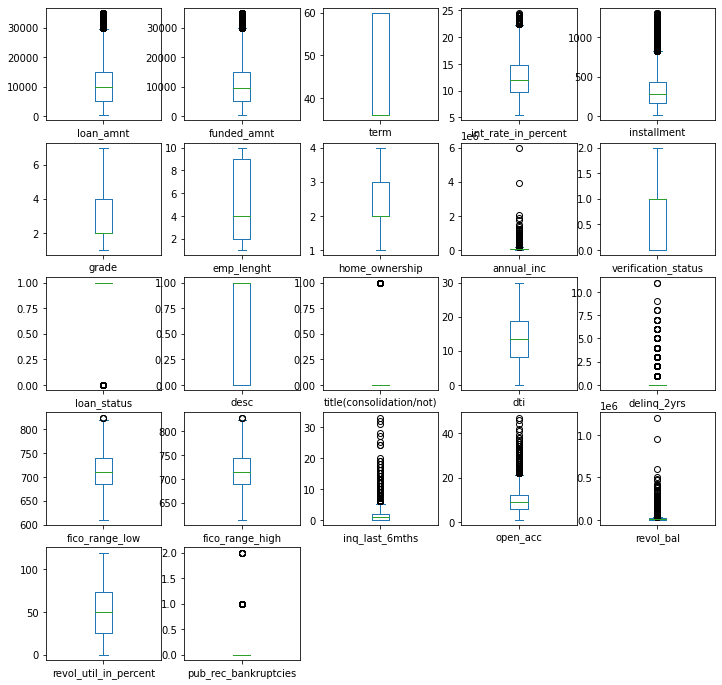

In [ ]:
df.plot(kind='box', figsize=(12, 12), subplots=True, layout=(5,5), sharex=False, sharey=False)
plt.show()

In [ ]:
z = np.abs(stats.zscore(df.annual_inc))
len(z[z>5])

117

In [ ]:
z = np.abs(stats.zscore(df.revol_bal))
len(z[z>5])

230

In [ ]:
# usuwam outliersy - zscore >5
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 5).all(axis=1)]

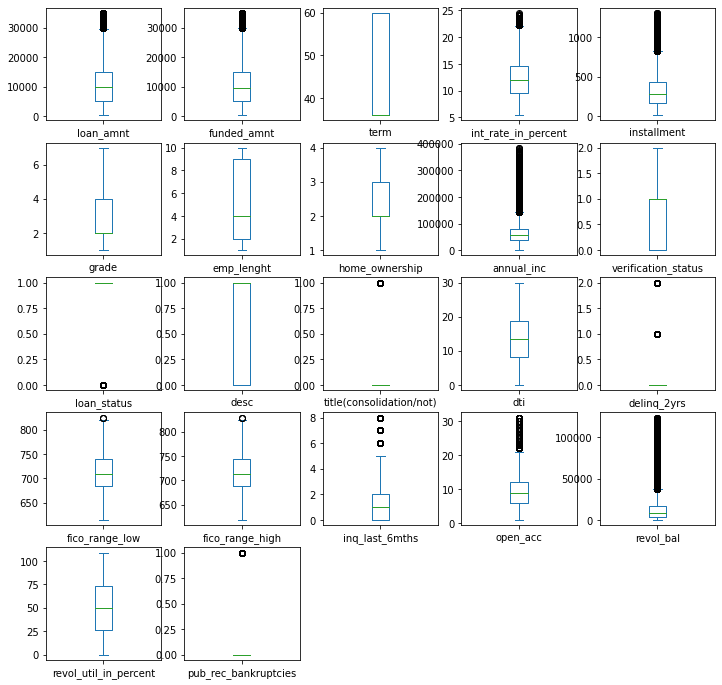

In [ ]:
df.plot(kind='box', figsize=(12, 12), subplots=True, layout=(5,5), sharex=False, sharey=False)
plt.show()

In [ ]:
# zmieniam kolejnośc kolumn by target był na końcu - lepiej widoczny w hitmapie
new_cols = [col for col in df.columns if col != 'loan_status'] + ['loan_status']
df = df[new_cols]

Text(0.5, 1.0, 'Correlation between features')

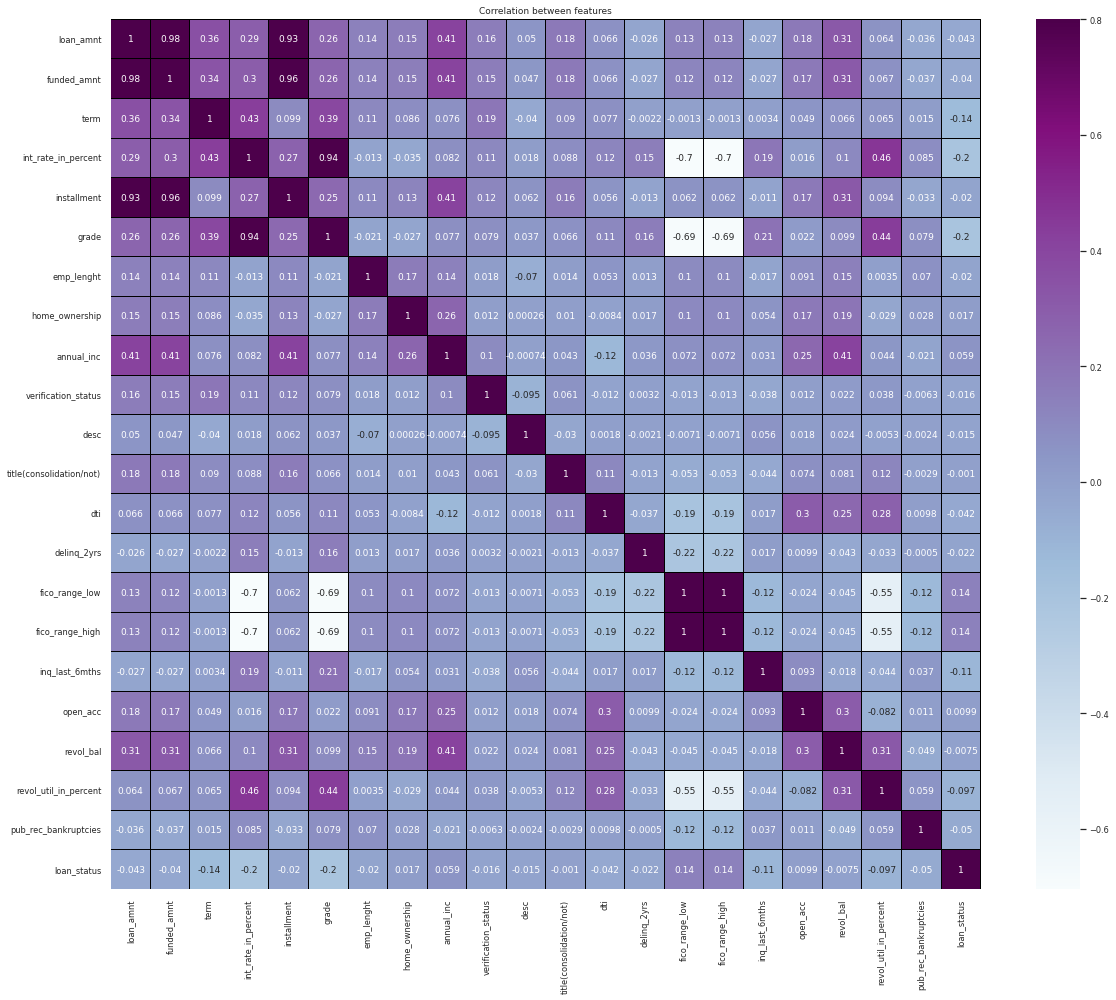

In [ ]:
corr_all = df.corr()
sns.set(font_scale=0.75)
plt.figure(figsize=(20, 16))

sns.heatmap(corr_all, vmax=.8, linewidths=0.01, square=True,annot=True,cmap="BuPu",linecolor="black")
plt.title('Correlation between features')

In [ ]:
# usuwam kolumnę funded_amnt - prawie całkowita korelacja z kolumną loan_amnt - dublowanie danych
df.drop(['funded_amnt'], axis = 1, inplace = True)

In [ ]:
# usuwam kolumnę installment - prawie całkowita korelacja z kolumną loan_amnt - dublowanie danych
df.drop(['installment'], axis = 1, inplace = True)

In [ ]:
# usuwam kolumnę fico_range_high - prawie całkowita korelacja z kolumną fico_range_low - dublowanie danych
df.drop(['fico_range_high'], axis = 1, inplace = True)

In [ ]:
# usuwam kolumnę int_rate_in_percent - b. wysoka koralacja (o,94) z grade - dublowanie danych
df.drop(columns = ['int_rate_in_percent'], inplace = True)

In [ ]:
# wyszukuję najwyższe korelacje
df1 = df.select_dtypes(['number']) 
corr = df1.corr()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df1.columns
    for i in range(0, df1.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df1.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df1)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 5))

Top Absolute Correlations
grade           fico_range_low           0.689634
fico_range_low  revol_util_in_percent    0.552178
grade           revol_util_in_percent    0.439670
loan_amnt       annual_inc               0.414084
annual_inc      revol_bal                0.412814
dtype: float64


Widać odwrotną korelację (-0.68) pomiędzy fico_range_low a grade. Co jednak jest oczywiste, gdyż:
"A FICO score is the number used to determine someone's creditworthiness, your credit score. Financial institutions and lenders use this as a guide to determine how much credit they can offer a borrower and at what interest rate. FICO scores can range from 300 to 850, the higher the number the better"


Widoczna jest również niewielka (0.55) korelacja pomiędzy fico_range_low revol_util_in_percent.
To jednak również nie ma dla nas znaczenia, gdyż revol_util_in_percent, czyli wskaźnik wykorzystania linii odnawialnej lub kwota kredytu, z którego korzysta pożyczkobiorca w stosunku do wszystkich dostępnych kredytów odnawialnych jest jednym z elementów branych pod uwagę w określaniu FICO pożyczkobiorcy.

Na ten moment nie widać żadnych istotnych korelacji między targetem - spłacalnością kredytu a pojedynczymi cechami - poddam to weryfikacji podczas analizy kolejnych ziennych.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05f089cb50>,
      dtype=object)

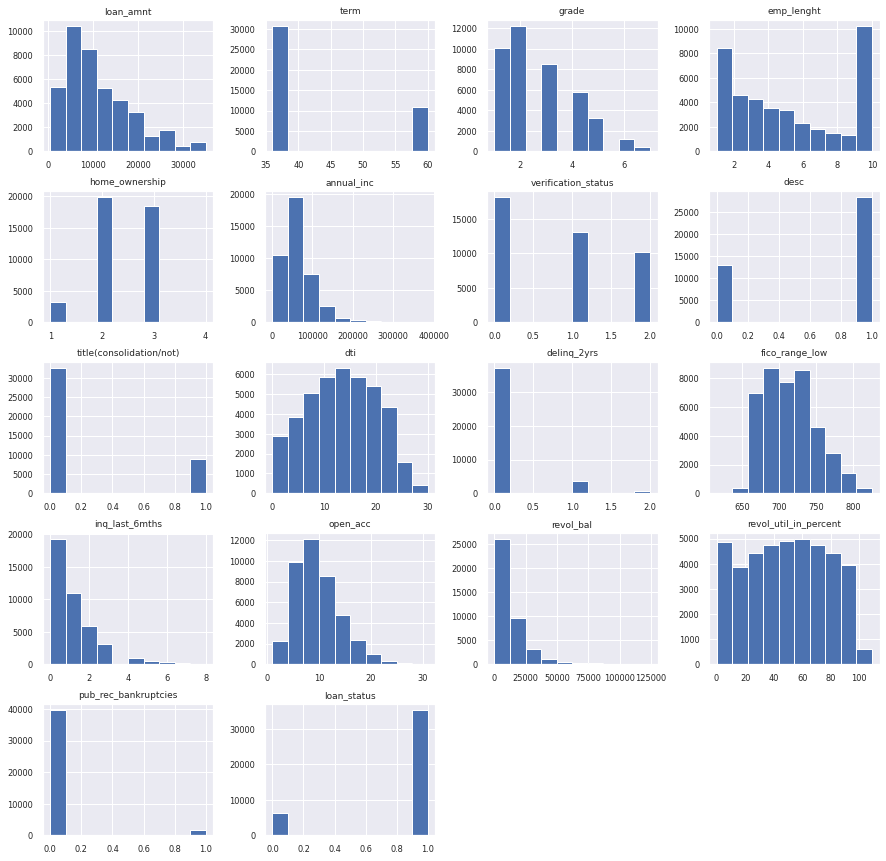

In [ ]:
df.hist(figsize=(15,15))

In [ ]:
# sns.pairplot(df, diag_kind='kde')

### ZMIENNA fico_range_low 

W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

In [ ]:
round(df['fico_range_low'].describe())

count    41501.0
mean       713.0
std         36.0
min        615.0
25%        685.0
50%        710.0
75%        740.0
max        825.0
Name: fico_range_low, dtype: float64

In [ ]:
df.fico_range_low.value_counts().sort_index()

615.0       1
625.0       1
630.0       4
635.0       4
640.0      89
645.0      92
650.0     106
655.0     110
660.0    1497
665.0    1726
670.0    1780
675.0    1941
680.0    2157
685.0    2255
690.0    2141
695.0    2141
700.0    2225
705.0    1937
710.0    1726
715.0    1862
720.0    1924
725.0    1869
730.0    1652
735.0    1632
740.0    1464
745.0    1304
750.0    1282
755.0    1081
760.0     964
765.0     782
770.0     786
775.0     646
780.0     567
785.0     403
790.0     414
795.0     333
800.0     245
805.0     187
810.0     123
815.0      27
820.0      18
825.0       3
Name: fico_range_low, dtype: int64

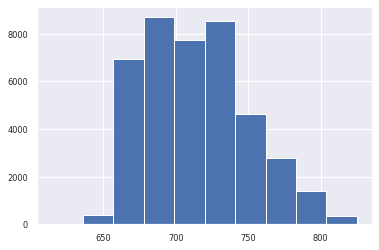

In [ ]:
df.fico_range_low.hist()

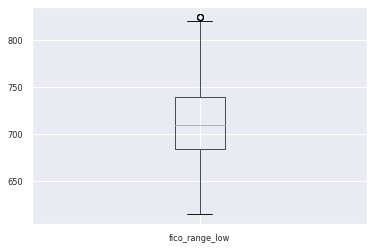

In [ ]:
# sprawdzam gdzie sa outliersy w tej zmiennej
boxplot = df.boxplot(column=['fico_range_low'])

In [ ]:
# sprawdzam jak dużo jest outlierów, by zdecydować czy je usuwam
Q1 = df.fico_range_low.quantile(q=0.25)
Q3 = df.fico_range_low.quantile(q=0.75)
L_outliers = Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Q1:', Q1)
print('Q3:', Q3)
print('Lower outliers: ', L_outliers) 
print('Upper outliers: ',U_outliers) 

print('Number of outliers in fico_range_low lower : ', df[df['fico_range_low']<L_outliers]['fico_range_low'].count())
print('Number of outliers in fico_range_low upper : ', df[df['fico_range_low']>U_outliers]['fico_range_low'].count())

print('% of Outlier in fico_range_low lower:', round(df[df['fico_range_low']<L_outliers]['fico_range_low'].count()*100/len(df)), '%')
print('% of Outlier in fico_range_low upper:', round(df[df['fico_range_low']>U_outliers]['fico_range_low'].count()*100/len(df)), '%')

Q1: 685.0
Q3: 740.0
Lower outliers:  602.5
Upper outliers:  822.5
Number of outliers in fico_range_low lower :  0
Number of outliers in fico_range_low upper :  3
% of Outlier in fico_range_low lower: 0 %
% of Outlier in fico_range_low upper: 0 %


In [ ]:
#odrzucam outliersy w tej kolumnie inną metodą (zscore powyżej abs(3))
df = df[np.abs(df.fico_range_low-df.fico_range_low.mean())<=(3*df.fico_range_low.std())]

In [ ]:
# sprawdzam ile próbek jest odchylonych od odchylenia standardowego powyżej abs(3)
z = np.abs(stats.zscore(df.fico_range_low))
len(z[z>3])

0

In [ ]:
round(df['fico_range_low'].describe())

count    41498.0
mean       713.0
std         36.0
min        615.0
25%        685.0
50%        710.0
75%        740.0
max        820.0
Name: fico_range_low, dtype: float64

In [ ]:
# sprawdzam korelację z targetem za pomocą ttestu
stat, p = ttest_rel(df['fico_range_low'], df['loan_status']) 
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same mean') # prawdopodobnie skorelowane dane -- zmienne zalezne (jeśli p większe niż 0.5)
else:
    print('Probably different mean')

stat=4034.134, p=0.000
Probably different mean


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


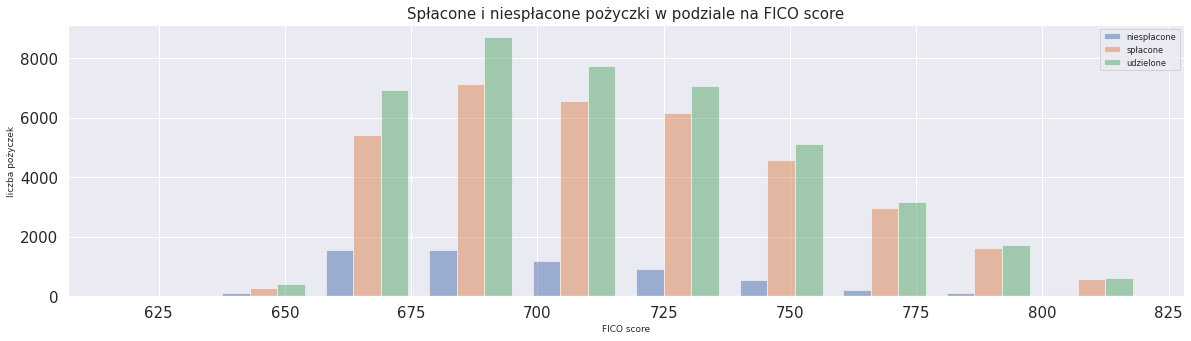

In [ ]:
# wykres korelacji spłacenia/niespłacenia pożyczki z FICO score 
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.fico_range_low[df.loan_status == 0], df.fico_range_low[df.loan_status == 1], df.fico_range_low], alpha = 0.5, label = ['niespłacone', 'spłacone','udzielone'])

ax.set_title('Spłacone i niespłacone pożyczki w podziale na FICO score', fontsize=15)
ax.set_xlabel('FICO score')
ax.set_ylabel('liczba pożyczek')
ax.tick_params(labelsize=15)
plt.legend()

In [ ]:
# sprawdzam jak dużo jest pożyczek zaciągniętych przy danej wysokości FICO
print('Liczba zaciągniętych pożyczek przy FICO niższym, równym niż 685: ', df[(df.fico_range_low <= 685)].fico_range_low.count())
print('Liczba zaciągniętych pożyczek przy FICO między 690 a 710         ', df[(df.fico_range_low >= 690)&(df.fico_range_low <= 710)].fico_range_low.count())
print('Liczba zaciągniętych pożyczek przy FICO między 715 a 740:        ', df[(df.fico_range_low >= 715)&(df.fico_range_low <= 740)].fico_range_low.count())
print('Liczba zaciągniętych pożyczek przy FICO równym, wyższym 745:      ', df[(df.fico_range_low >= 745)].fico_range_low.count())

Liczba zaciągniętych pożyczek przy FICO niższym, równym niż 685:  11763
Liczba zaciągniętych pożyczek przy FICO między 690 a 710          10170
Liczba zaciągniętych pożyczek przy FICO między 715 a 740:         10403
Liczba zaciągniętych pożyczek przy FICO równym, wyższym 745:       9162


In [ ]:
# sprawdzam jak duży procent w danym przedziale FICO stanowią niespłacone pożyczki w zależności od wysokości FICO
niesplacone_FICO_685= df[(df.fico_range_low <= 685) & (df.loan_status == 0)].fico_range_low.count()
niesplacone_FICO_690 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0)].fico_range_low.count()
niesplacone_FICO_715 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0)].fico_range_low.count()
niesplacone_FICO_745 = df[(df.fico_range_low >= 745) & (df.loan_status == 0)].fico_range_low.count()

print('Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685::       ',niesplacone_FICO_685, '   Jest to:', round((niesplacone_FICO_685*100)/11763,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pozyczek przy FICO między 690 a 710:               ', niesplacone_FICO_690, '   Jest to:', round((niesplacone_FICO_690*100)/10170,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pożyczek przy FICO między 715 a 740:               ', niesplacone_FICO_715, '   Jest to:', round((niesplacone_FICO_715*100)/10403,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pożyczek przy FICO równym/wyższym niż 745:          ',  niesplacone_FICO_745,'   Jest to: ', round((niesplacone_FICO_745*100)/9162,2), '% zaciągniętych pożyczek przy tym poziomie FICO')

Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685::        2481    Jest to: 21.09 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pozyczek przy FICO między 690 a 710:                1672    Jest to: 16.44 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pożyczek przy FICO między 715 a 740:                1325    Jest to: 12.74 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pożyczek przy FICO równym/wyższym niż 745:           744    Jest to:  8.12 % zaciągniętych pożyczek przy tym poziomie FICO


> ### WNIOSKI (fico_range_low) :
Im niższy FICO score tym więcej niespłaconych pożyczek - tym większe ryzyko niespłacenia zobowiązania.

> W analizowanej bazie liczba niespłaconych pożyczek przy najniższym analizowanym FICO score jest o 13 pp wyższa niż przy najwyższym FICO Score.


###ZMIENNA loan_amnt - wysokość pożyczki

#### Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?

In [ ]:
round(df['loan_amnt'].describe())

count    41498.0
mean     11090.0
std       7392.0
min        500.0
25%       5206.0
50%       9800.0
75%      15000.0
max      35000.0
Name: loan_amnt, dtype: float64

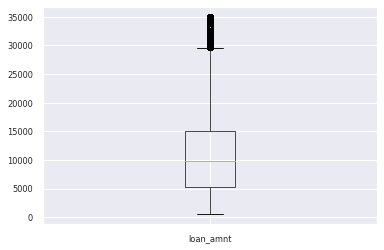

In [ ]:
# sprawdzam gdzie sa outliersy w tej zmiennej
boxplot = df.boxplot(column=['loan_amnt'])

In [ ]:
# sprawdzam jak dużo jest outlierów, by zdecydować czy je usuwam
Q1 = df.loan_amnt.quantile(q=0.25)
Q3 = df.loan_amnt.quantile(q=0.75)
L_outliers = Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Q1:', Q1)
print('Q3:', Q3)
print('Lower outliers: ', L_outliers) 
print('Upper outliers: ',U_outliers) 

print('Number of outliers in loan_amnt lower : ', df[df['loan_amnt']<L_outliers]['loan_amnt'].count())
print('Number of outliers in loan_amnt upper : ', df[df['loan_amnt']>U_outliers]['loan_amnt'].count())

print('% of Outlier in loan_amnt lower:', round(df[df['loan_amnt']<L_outliers]['loan_amnt'].count()*100/len(df)), '%')
print('% of Outlier in loan_amnt upper:', round(df[df['loan_amnt']>U_outliers]['loan_amnt'].count()*100/len(df)), '%')

Q1: 5206.25
Q3: 15000.0
Lower outliers:  -9484.375
Upper outliers:  29690.625
Number of outliers in loan_amnt lower :  0
Number of outliers in loan_amnt upper :  1196
% of Outlier in loan_amnt lower: 0 %
% of Outlier in loan_amnt upper: 3 %


In [ ]:
# sprawdzam ile jest outliersów z zscore > 4
z = np.abs(stats.zscore(df.loan_amnt))
len(z[z>4])

0

In [ ]:
# sprawdzam ile jest outliersów z zscore > 3
z = np.abs(stats.zscore(df.loan_amnt))
len(z[z>3])

709

Jest sporo outliersów. Nie przekraczają one zscore = 4. Póki co zostawiam je. 

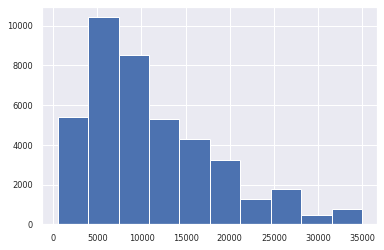

In [ ]:
df.loan_amnt.hist()

In [ ]:
#sprawdzam korelację z targetem
df.loan_amnt.corr(df.loan_status)

-0.04304621202387847

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


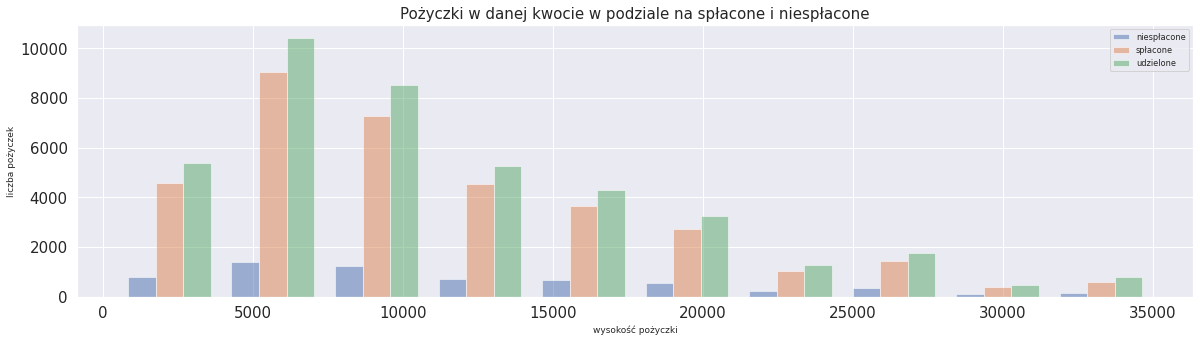

In [ ]:
# wykres pożyczek w danej kwocie w podziale na spłacone i niespłacone
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.loan_amnt[df.loan_status == 0], df.loan_amnt[df.loan_status == 1], df.loan_amnt], alpha = 0.5, label = ['niespłacone', 'spłacone','udzielone'])

ax.set_title('Pożyczki w danej kwocie w podziale na spłacone i niespłacone', fontsize=15)
ax.set_xlabel('wysokość pożyczki')
ax.set_ylabel('liczba pożyczek')
ax.tick_params(labelsize=15)
plt.legend()

In [ ]:
df.loan_status.count()

41498

In [ ]:
# sprawdzam ile zostało zaciągniętych pożyczek w danych przedziałach
print('Liczba zaciągniętych pożyczek w kwocie poniżej 5 000:       ', df[(df.loan_amnt < 5000)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie od 5 000 do 9 999:  ', df[(df.loan_amnt >= 5000)&(df.loan_amnt <10000)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie od 10 000 do 14 999: ', df[(df.loan_amnt >= 10000)&(df.loan_amnt <15000)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie od 15 000 do 24 999: ', df[(df.loan_amnt >= 15000)&(df.loan_amnt <25000)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie powyżej 25 000:      ', df[(df.loan_amnt >= 25000)].loan_amnt.count())

Liczba zaciągniętych pożyczek w kwocie poniżej 5 000:        8031
Liczba zaciągniętych pożyczek w kwocie od 5 000 do 9 999:   12843
Liczba zaciągniętych pożyczek w kwocie od 10 000 do 14 999:  9254
Liczba zaciągniętych pożyczek w kwocie od 15 000 do 24 999:  8360
Liczba zaciągniętych pożyczek w kwocie powyżej 25 000:       3010


In [ ]:
# sprawdzam jak duży procent w danych przedziałach stanowią niespłacone pożyczki
niesplacone_do_5_tys = df[(df.loan_amnt < 5000) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_od_5_do_10_tys = df[(df.loan_amnt >= 5000)&(df.loan_amnt <10000) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_od_10_do_15_tys = df[(df.loan_amnt >= 10000)&(df.loan_amnt <15000) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_od_15_do_25_tys = df[(df.loan_amnt >= 15000)&(df.loan_amnt <25000) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_powyżej_25tys = df[(df.loan_amnt >= 25000) & (df.loan_status == 0)].loan_amnt.count()
print('Liczba niespłaconych pożyczek w kwocie poniżej 5 000:       ',niesplacone_do_5_tys, '   Jest to:', round((niesplacone_do_5_tys*100)/8031,2), '% zaciągniętych pożyczek do tej wysokości')
print('Liczba niespłaconych pożyczek w kwocie od 5 000 do 9 999:   ', niesplacone_od_5_do_10_tys, '   Jest to:', round((niesplacone_od_5_do_10_tys*100)/12844,2), '% zaciągniętych pożyczek w tym przedziale')
print('Liczba niespłaconych pożyczek w kwocie od 10 000 do 14 999: ', niesplacone_od_10_do_15_tys, '   Jest to:', round((niesplacone_od_10_do_15_tys*100)/9254,2), '% zaciągniętych pożyczek w tym przedziale')
print('Liczba niespłaconych pożyczek w kwocie od 15 000 do 24 999: ', niesplacone_od_15_do_25_tys, '   Jest to:', round((niesplacone_od_15_do_25_tys*100)/8362,2), '% zaciągniętych pożyczek w tym przedziale')
print('Liczba niespłaconych pożyczek w kwocie powyżej 25 0000:      ',  niesplacone_powyżej_25tys, '   Jest to:', round((niesplacone_powyżej_25tys*100)/3010,2), '% zaciągniętych pożyczek powyżej tej kwoty')

Liczba niespłaconych pożyczek w kwocie poniżej 5 000:        1157    Jest to: 14.41 % zaciągniętych pożyczek do tej wysokości
Liczba niespłaconych pożyczek w kwocie od 5 000 do 9 999:    1794    Jest to: 13.97 % zaciągniętych pożyczek w tym przedziale
Liczba niespłaconych pożyczek w kwocie od 10 000 do 14 999:  1290    Jest to: 13.94 % zaciągniętych pożyczek w tym przedziale
Liczba niespłaconych pożyczek w kwocie od 15 000 do 24 999:  1383    Jest to: 16.54 % zaciągniętych pożyczek w tym przedziale
Liczba niespłaconych pożyczek w kwocie powyżej 25 0000:       598    Jest to: 19.87 % zaciągniętych pożyczek powyżej tej kwoty


In [ ]:
#jaki % wszystkich pożyczek to pożyczki powyżej 25 tys?
100*(df[df.loan_amnt > 25000].loan_amnt.count()/df.loan_status.count())

3.824280688225939

In [ ]:
# ile pożyczek powyżej 25 tys. zostało udzielonych nominalnie?
df[df.loan_amnt > 25000].loan_amnt.count()

1587

In [ ]:
# sprawdzam to samo przy nieco innym podziale na przedziały (bardziej wyrównanym pod względem liczby próbek wchodzących do przedziału)
print('Liczba zaciągniętych pożyczek w kwocie poniżej 5 500:      ', df[(df.loan_amnt < 5500)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie od 5 500 do 9 999:  ', df[(df.loan_amnt >= 5500)&(df.loan_amnt <10000)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie od 10 000 do 15 499:', df[(df.loan_amnt >= 10000)&(df.loan_amnt <15500)].loan_amnt.count())
print('Liczba zaciągniętych pożyczek w kwocie powyżej 15 500:      ', df[(df.loan_amnt >= 15500)].loan_amnt.count())

Liczba zaciągniętych pożyczek w kwocie poniżej 5 500:       10557
Liczba zaciągniętych pożyczek w kwocie od 5 500 do 9 999:   10317
Liczba zaciągniętych pożyczek w kwocie od 10 000 do 15 499: 11357
Liczba zaciągniętych pożyczek w kwocie powyżej 15 500:       9267


In [ ]:
niesplacone_do_5_5_tys = df[(df.loan_amnt < 5500) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_od_5_5_do_10_tys = df[(df.loan_amnt >= 5500)&(df.loan_amnt <10000) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_od_10_do_15_5_tys = df[(df.loan_amnt >= 10000)&(df.loan_amnt <15500) & (df.loan_status == 0)].loan_amnt.count()
niesplacone_powyżej_15_5tys = df[(df.loan_amnt >= 15500) & (df.loan_status == 0)].loan_amnt.count()
print('Liczba niespłaconych pożyczek w kwocie poniżej 5 500:       ',niesplacone_do_5_5_tys, '   Jest to:', round((niesplacone_do_5_5_tys*100)/10557,2), '% zaciągniętych pożyczek do tej wysokości')
print('Liczba niespłaconych pożyczek w kwocie od 5 500 do 9 999:   ', niesplacone_od_5_5_do_10_tys, '   Jest to:', round((niesplacone_od_5_5_do_10_tys*100)/10318,2), '% zaciągniętych pożyczek w tym przedziale')
print('Liczba niespłaconych pożyczek w kwocie od 10 000 do 15 499: ', niesplacone_od_10_do_15_tys, '   Jest to:', round((niesplacone_od_10_do_15_tys*100)/11357,2), '% zaciągniętych pożyczek w tym przedziale')
print('Liczba niespłaconych pożyczek w kwocie powyżej 15 500:      ',  niesplacone_powyżej_15_5tys, '   Jest to:', round((niesplacone_powyżej_15_5tys*100)/9269,2), '% zaciągniętych pożyczek powyżej tej kwoty')

Liczba niespłaconych pożyczek w kwocie poniżej 5 500:        1551    Jest to: 14.69 % zaciągniętych pożyczek do tej wysokości
Liczba niespłaconych pożyczek w kwocie od 5 500 do 9 999:    1400    Jest to: 13.57 % zaciągniętych pożyczek w tym przedziale
Liczba niespłaconych pożyczek w kwocie od 10 000 do 15 499:  1290    Jest to: 11.36 % zaciągniętych pożyczek w tym przedziale
Liczba niespłaconych pożyczek w kwocie powyżej 15 500:       1667    Jest to: 17.98 % zaciągniętych pożyczek powyżej tej kwoty


In [ ]:
#jaki % wszystkich pożyczek to pożyczki powyżej 15,5 tys?
100*(df[df.loan_amnt >= 15500].loan_amnt.count()/df.loan_status.count())

22.331196684177552

In [ ]:
# ile pożyczek powyżej 15,5 tys. zostało udzielonych nominalnie?
df[df.loan_amnt >= 15500].loan_amnt.count()

9267

> ### WNIOSKI (loan_amnt): 

> Najwyższy procent niespłaconych pożyczek jest w grupie pożyczek powyżej 25 tys. Przy czym tych udzielono jedynie 1587 razy (mniej niż 4% wszystkich pożyczek), więc jest to zbyt mała liczba, aby na jej podstawie wyciągać wnioski. 

> Jeśli jednak policzyć liczbę niespłaconych pożyczek dla kwot powyżej 15,5 tys, wówczas analiza odbywa się już na 9269 próbek, które stanowią ponad 22% wszystkich pożyczek i na tej podstawie można już wnioskować. W tym przedziale jest blisko 18% niespłaconych pożyczek - najwięcej ze wszystkich przedziałów.

> % niespłaconych pożyczek w tym przedziale (powyżej 15,5tys) jest o 3-6 pp wyższy niż w innych przedziałach.

> Co ciekawe drugi w kolejności co do największej liczby niespłaconych pożyczek jest przedział pożyczek do wysokości 5,5 tys. 


###ZMIENNA emp_lenght - długość zatrudnienia



#### W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?


In [ ]:
round(df.emp_lenght.describe())

count    41498.0
mean         5.0
std          3.0
min          1.0
25%          2.0
50%          4.0
75%          9.0
max         10.0
Name: emp_lenght, dtype: float64

In [ ]:
df.emp_lenght.value_counts()

10.0    10221
1.0      8403
2.0      4619
3.0      4284
4.0      3573
5.0      3393
6.0      2325
7.0      1832
8.0      1540
9.0      1308
Name: emp_lenght, dtype: int64

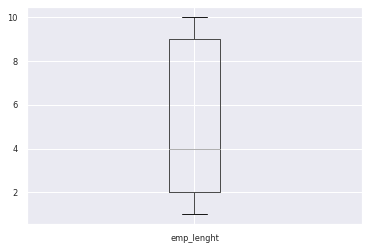

In [ ]:
# sprawdzam gdzie sa outliersy w tej zmiennej
boxplot = df.boxplot(column=['emp_lenght'])

In [ ]:
# sprawdzenie ile próbek jest odchylone od odchylenia standardowego powyżej abs(3)
#wskaźnik z powyżej 2 lub 3 to znaczy, ze duże odchylenie. Dla normalnych prbek powienien przyjmować wskaźnik od -1 do 1
z = np.abs(stats.zscore(df.emp_lenght))
len(z[z>3])

0

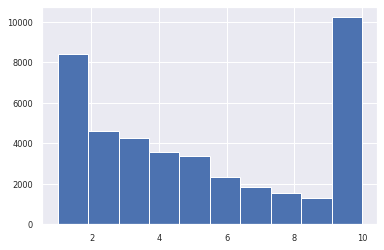

In [ ]:
df.emp_lenght.hist()

In [ ]:
Q1 = df.emp_lenght.quantile(q=0.25)
Q3 = df.emp_lenght.quantile(q=0.75)
L_outliers = Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Q1:', Q1)
print('Q3:', Q3)
print('Lower outliers: ', L_outliers) # czy ten Lower outlier nie jest zbyt niski?
print('Upper outliers: ',U_outliers) 

print('Number of outliers in emp_lenght lower : ', df[df['emp_lenght']<L_outliers]['emp_lenght'].count())
print('Number of outliers in emp_lenght upper : ', df[df['emp_lenght']>U_outliers]['emp_lenght'].count())

print('% of Outlier in emp_lenght lower:', round(df[df['emp_lenght']<L_outliers]['emp_lenght'].count()*100/len(df)), '%')
print('% of Outlier in emp_lenght upper:', round(df[df['emp_lenght']>U_outliers]['emp_lenght'].count()*100/len(df)), '%')

Q1: 2.0
Q3: 9.0
Lower outliers:  -8.5
Upper outliers:  19.5
Number of outliers in emp_lenght lower :  0
Number of outliers in emp_lenght upper :  0
% of Outlier in emp_lenght lower: 0 %
% of Outlier in emp_lenght upper: 0 %


In [ ]:
# sprawdzam korelację z targetem
df.emp_lenght.corr(df.loan_status)

-0.01965456858275305

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


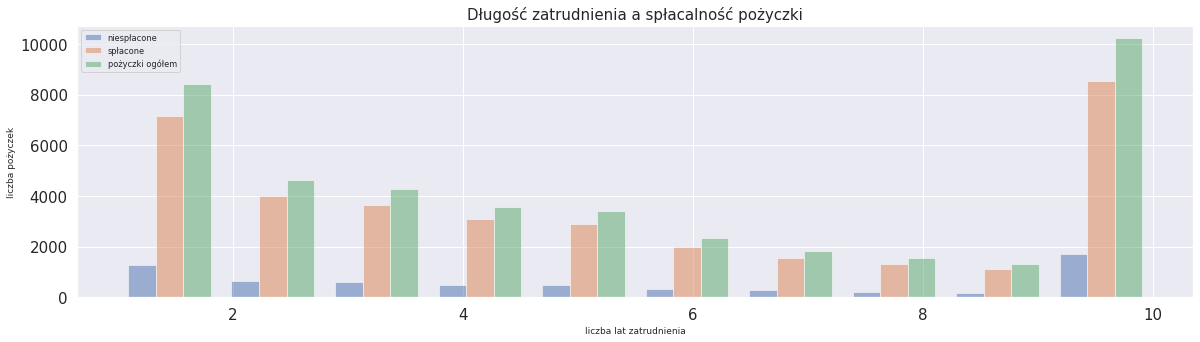

In [ ]:
# wykres zestawiający długość zatrudnienia ze spłacalnością pożyczki
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.emp_lenght[df.loan_status == 0], df.emp_lenght[df.loan_status == 1], df.emp_lenght], alpha = 0.5, label = ['niespłacone', 'spłacone','pożyczki ogółem'])

ax.set_title('Długość zatrudnienia a spłacalność pożyczki', fontsize=15)
ax.set_xlabel('liczba lat zatrudnienia')
ax.set_ylabel('liczba pożyczek')
ax.tick_params(labelsize=15)
plt.legend()


In [ ]:
df.loan_status.count()

41498

In [ ]:
# sprawdzam ile mamy osób o danym okresie zatrudnienia
print('Liczba zaciągniętych pożyczek przy zatrudnieniu 1 rok:                 ', df[(df.emp_lenght == 1.0)].emp_lenght.count())
print('Liczba zaciągniętych pożyczek przy zatrudnieniu 2-4  lata:            ', df[(df.emp_lenght >=2.0)&(df.emp_lenght <= 4.0)].emp_lenght.count())
print('Liczba zaciągniętych pożyczek przy zatrudnieniu 5-8  lat:              ', df[(df.emp_lenght >= 5.0)&(df.emp_lenght <= 8.0)].emp_lenght.count())
print('Liczba zaciągniętych pożyczek przy zatrudnieniu 9-10 lat:             ', df[(df.emp_lenght >= 9.0)&(df.emp_lenght <= 10.0)].emp_lenght.count())

Liczba zaciągniętych pożyczek przy zatrudnieniu 1 rok:                  8403
Liczba zaciągniętych pożyczek przy zatrudnieniu 2-4  lata:             12476
Liczba zaciągniętych pożyczek przy zatrudnieniu 5-8  lat:               9090
Liczba zaciągniętych pożyczek przy zatrudnieniu 9-10 lat:              11529


In [ ]:
# sprawdzam jak duży procent pożyczek zaciągniętych przez osoby o danym okresie zatrudnienia stanowią niespłacone pożyczki
niesplacone_zatr_1 = df[(df.emp_lenght == 1.0) & (df.loan_status == 0)].emp_lenght.count()
niesplacone_zatr_2_4 = df[(df.emp_lenght >=2.0)&(df.emp_lenght <= 4.0) & (df.loan_status == 0)].emp_lenght.count()
niesplacone_zatr_5_8 = df[(df.emp_lenght >= 5.0)&(df.emp_lenght <= 8.0) & (df.loan_status == 0)].emp_lenght.count()
niesplacone_zatr_9_10 = df[(df.emp_lenght >= 9.0)&(df.emp_lenght <= 10.0) & (df.loan_status == 0)].emp_lenght.count()
print('Liczba niespłaconych pożyczek przy zatrudnieniu 1 rok               ',niesplacone_zatr_1,    '   Jest to:', round((niesplacone_zatr_1*100)/8403,2), '% pożyczek zaciągniętych przez osoby o takim zatrudnieniu')
print('Liczba niespłaconych pożyczek przy zatrudnieniu 2-4 lata:           ', niesplacone_zatr_2_4, '   Jest to:', round((niesplacone_zatr_2_4*100)/12476,2), '% pożyczek zaciągniętych przez osoby o takim zatrudnieniu')
print('Liczba niespłaconych pożyczek przy zatrudnieniu 5-8 lat:            ', niesplacone_zatr_5_8, '   Jest to:', round((niesplacone_zatr_5_8*100)/9090,2), '% pożyczek zaciągniętych przez osoby o takim zatrudnieniu')
print('Liczba niespłaconych pożyczek przy zatrudnieniu 9-10 lat:           ', niesplacone_zatr_9_10 ,'   Jest to:', round((niesplacone_zatr_9_10 *100)/11529,2), '% pożyczek zaciągniętych przez osoby o takim zatrudnieniu')

Liczba niespłaconych pożyczek przy zatrudnieniu 1 rok                1256    Jest to: 14.95 % pożyczek zaciągniętych przez osoby o takim zatrudnieniu
Liczba niespłaconych pożyczek przy zatrudnieniu 2-4 lata:            1752    Jest to: 14.04 % pożyczek zaciągniętych przez osoby o takim zatrudnieniu
Liczba niespłaconych pożyczek przy zatrudnieniu 5-8 lat:             1344    Jest to: 14.79 % pożyczek zaciągniętych przez osoby o takim zatrudnieniu
Liczba niespłaconych pożyczek przy zatrudnieniu 9-10 lat:            1870    Jest to: 16.22 % pożyczek zaciągniętych przez osoby o takim zatrudnieniu


> ### WNIOSKI (emp_lenght): 

> Długość zatrudnienia - samodzielnie - nie wpływa, w sposób jednoznaczny, na spłacenie lub niespłacenie pożyczki. Liczba niespłaconych pożyczek utrzymuje się na podobnym poziomie niezależnie od długości zatrudnienia.
> Odrobinę wyższy procent niespłaconych pożyczek jest w grupie osób zatrudnionych 9-10 lat. Jest to różnica 1,5-2 pp. w stosunku do pozostałych przedziałów.


### ZMIENNA annual_inc - roczny dochód

#### W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?


In [ ]:
round(df.annual_inc.describe())

count     41498.0
mean      66692.0
std       39605.0
min        1896.0
25%       40000.0
50%       58000.0
75%       81500.0
max      385000.0
Name: annual_inc, dtype: float64

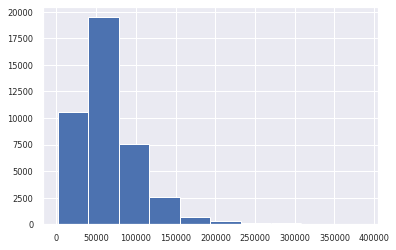

In [ ]:
df.annual_inc.hist()

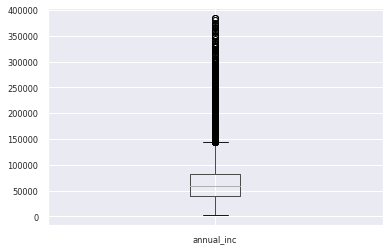

In [ ]:
# sprawdzam gdzie sa outliersy w tej zmiennej
boxplot = df.boxplot(column=['annual_inc'])

In [ ]:
# sprawdzam ile próbek jest odchylonych od odchylenia standardowego powyżej abs(3)
z = np.abs(stats.zscore(df.annual_inc))
len(z[z>3])

715

In [ ]:
Q1 = df.annual_inc.quantile(q=0.25)
Q3 = df.annual_inc.quantile(q=0.75)
L_outliers = Q1-1.5*(Q3-Q1)
U_outliers=Q3+1.5*(Q3-Q1)
print('Q1:', Q1)
print('Q3:', Q3)
print('Lower outliers: ', L_outliers) 
print('Upper outliers: ',U_outliers) 

print('Number of outliers in annual_inc lower : ', df[df['annual_inc']<L_outliers]['annual_inc'].count())
print('Number of outliers in annual_inc upper : ', df[df['annual_inc']>U_outliers]['annual_inc'].count())

print('% of Outlier in annual_inc lower:', round(df[df['annual_inc']<L_outliers]['annual_inc'].count()*100/len(df)), '%')
print('% of Outlier in annual_inc upper:', round(df[df['annual_inc']>U_outliers]['annual_inc'].count()*100/len(df)), '%')

Q1: 40000.0
Q3: 81500.0
Lower outliers:  -22250.0
Upper outliers:  143750.0
Number of outliers in annual_inc lower :  0
Number of outliers in annual_inc upper :  1879
% of Outlier in annual_inc lower: 0 %
% of Outlier in annual_inc upper: 5 %


In [ ]:
#sprawdzam korelację z targetem
df.annual_inc.corr(df.loan_status)

0.05942248797771605

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


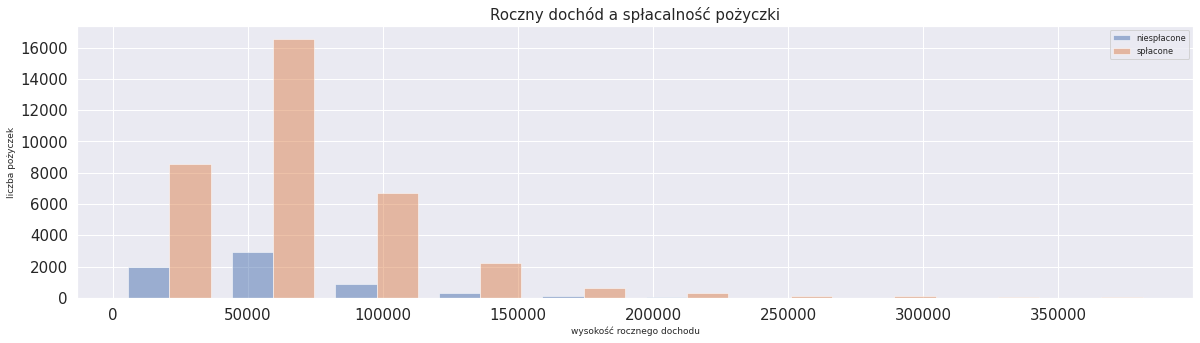

In [ ]:
# wykres zestawiający spłacalność pożyczki z dochodem rocznym
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.annual_inc[df.loan_status == 0], df.annual_inc[df.loan_status == 1]], alpha = 0.5, label = ['niespłacone', 'spłacone'])

ax.set_title('Roczny dochód a spłacalność pożyczki', fontsize=15)
ax.set_xlabel('wysokość rocznego dochodu')
ax.set_ylabel('liczba pożyczek')
ax.tick_params(labelsize=15)
plt.legend()


In [ ]:
df.loan_status[df.loan_status == 0].count()

6222

In [ ]:
print('Liczba zaciągniętych pożyczek przy dochodzie poniżej 40 000:              ', df[(df.annual_inc < 40000)].annual_inc.count())
print('Liczba zaciągniętych pożyczek przy rocznym dochodzie od 40 000 do 69 999:', df[(df.annual_inc >= 40000)&(df.annual_inc <70000)].annual_inc.count())
print('Liczba zaciągniętych pożyczek przy rocznym dochodzie od 70 000 do 99 999: ', df[(df.annual_inc >= 70000)&(df.annual_inc <100000)].annual_inc.count())
print('Liczba zaciągniętych pożyczek przy rocznym dochodzie powyżej 100 0000:    ', df[(df.annual_inc >= 100000)].annual_inc.count())

Liczba zaciągniętych pożyczek przy dochodzie poniżej 40 000:               9580
Liczba zaciągniętych pożyczek przy rocznym dochodzie od 40 000 do 69 999: 16718
Liczba zaciągniętych pożyczek przy rocznym dochodzie od 70 000 do 99 999:  8926
Liczba zaciągniętych pożyczek przy rocznym dochodzie powyżej 100 0000:     6274


In [ ]:
niesplacone_dochod_do_40_tys = df[(df.annual_inc < 40000) & (df.loan_status == 0)].annual_inc.count()
niesplacone_od_40_do_70_tys = df[(df.annual_inc >= 40000)&(df.annual_inc <70000) & (df.loan_status == 0)].annual_inc.count()
niesplacone_od_70_do_100_tys = df[(df.annual_inc >= 70000)&(df.annual_inc <100000) & (df.loan_status == 0)].annual_inc.count()
niesplacone_powyżej_100_tys = df[(df.annual_inc >= 100000) & (df.loan_status == 0)].annual_inc.count()
print('Liczba niespłaconych pożyczek przy rocznym dochodzie poniżej 40 000:       ',niesplacone_dochod_do_40_tys, '   Jest to:', round((niesplacone_dochod_do_40_tys*100)/9580,2), '% pożyczek zaciągniętych przez osoby o takim dochodzie')
print('Liczba niespłaconych pożyczek przy rocznym dochodzie od 40 000 do 69 999:  ', niesplacone_od_40_do_70_tys, '   Jest to:', round((niesplacone_od_40_do_70_tys*100)/16719,2), '% pożyczek zaciągniętych przez osoby o takim dochodzie')
print('Liczba niespłaconych pożyczek przy rocznym dochodzie od 70 000 do 99 999:  ', niesplacone_od_70_do_100_tys, '   Jest to:', round((niesplacone_od_70_do_100_tys*100)/8926,2), '% pożyczek zaciągniętych przez osoby o takim dochodzie')
print('Liczba niespłaconych pożyczek przy rocznym dochodzie powyżej 100 000:      ', niesplacone_powyżej_100_tys,'   Jest to:', round((niesplacone_powyżej_100_tys*100)/6276,2), '% pożyczek zaciągniętych przez osoby o takim dochodzie')

Liczba niespłaconych pożyczek przy rocznym dochodzie poniżej 40 000:        1768    Jest to: 18.46 % pożyczek zaciągniętych przez osoby o takim dochodzie
Liczba niespłaconych pożyczek przy rocznym dochodzie od 40 000 do 69 999:   2589    Jest to: 15.49 % pożyczek zaciągniętych przez osoby o takim dochodzie
Liczba niespłaconych pożyczek przy rocznym dochodzie od 70 000 do 99 999:   1152    Jest to: 12.91 % pożyczek zaciągniętych przez osoby o takim dochodzie
Liczba niespłaconych pożyczek przy rocznym dochodzie powyżej 100 000:       713    Jest to: 11.36 % pożyczek zaciągniętych przez osoby o takim dochodzie


> ### WNIOSKI (annual_inc): 

> Wraz ze spadkiem dochodu rocznego rośnie liczba niespłaconych zobowiązań. Można więc uznać, że im niższe dochody roczne, tym większe ryzyko braku spłaty zobowiązania. W grupie o dochodach poniżej 40 tys rocznie ponad 18% pożyczek nie zostało spłaconych.

> Różnica pomiędzy liczbą niespłaconych pożyczek zaciągniętych przez osoby o najniższych oraz nawyższych dochodach wynosi mniej więcej 7pp.


### ZMIENNA home_ownership - status kredytu hipotecznego

#### W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?
OWN - 1,   RENT - 2,   MORTGAGE - 3,   OTHER oraz NONE - 4


In [ ]:
df.home_ownership.value_counts()

2    19844
3    18368
1     3156
4      130
Name: home_ownership, dtype: int64

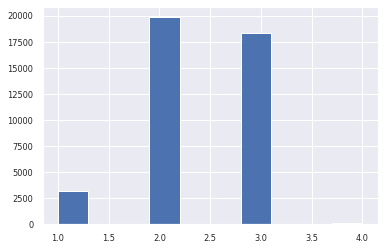

In [ ]:
df.home_ownership.hist()

In [ ]:
# sprawdzam korelację z targetem za pomocą ttestu
stat, p = ttest_rel(df['home_ownership'], df['loan_status']) 
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same mean') # prawdopodobnie skorelowane dane -- zmienne zalezne
else:
    print('Probably different mean')

stat=433.540, p=0.000
Probably different mean


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


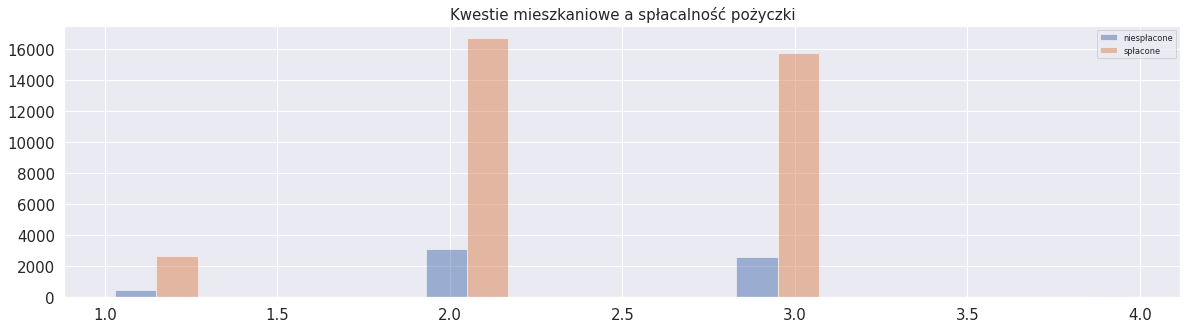

In [ ]:
# wykres zestawiający spłacalność pożyczki ze statusem mieszkaniowym
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.hist([df.home_ownership[df.loan_status == 0], df.home_ownership[df.loan_status == 1]], alpha = 0.5, label = ['niespłacone', 'spłacone'])

ax.set_title('Kwestie mieszkaniowe a spłacalność pożyczki', fontsize=15)
ax.tick_params(labelsize=15)
plt.legend()


In [ ]:
df.shape

(41498, 22)

In [ ]:
df.home_ownership.value_counts()

2    19844
3    18368
1     3156
4      130
Name: home_ownership, dtype: int64

In [ ]:
rent = df[(df.home_ownership == 2) & (df.loan_status == 0)].home_ownership.count()
own = df[(df.home_ownership == 1) & (df.loan_status == 0)].home_ownership.count()
mortgage = df[(df.home_ownership == 3) & (df.loan_status == 0)].home_ownership.count()
other = df[(df.home_ownership == 4) & (df.loan_status == 0)].home_ownership.count()
print('Liczba niespłaconych pożyczek przy RENT:     ',rent, '   Jest to:', round((rent*100)/19844, 2), '% zaciągniętych pożyczek przez osoby wynajmujące mieszkanie')
print('Liczba niespłaconych pożyczek przy OWN:       ', own, '   Jest to:', round((own*100)/3156,2), '% zaciągniętych pożyczek pzez osoby posiadające własne mieszkanie')
print('Liczba niespłaconych pożyczek przy MORTGAGE: ', mortgage, '   Jest to:', round((mortgage*100)/18368,2), '% zaciągniętych pożyczek przez osoby posiadające kredyt hipoteczny')
print('Liczba niespłaconych pożyczek przy OTHER:      ', other, '   Jest to:', round((other*100)/130,2), '% zaciągniętych pożyczek przez osoby sklasyfikowane inaczej')

Liczba niespłaconych pożyczek przy RENT:      3142    Jest to: 15.83 % zaciągniętych pożyczek przez osoby wynajmujące mieszkanie
Liczba niespłaconych pożyczek przy OWN:        474    Jest to: 15.02 % zaciągniętych pożyczek pzez osoby posiadające własne mieszkanie
Liczba niespłaconych pożyczek przy MORTGAGE:  2578    Jest to: 14.04 % zaciągniętych pożyczek przez osoby posiadające kredyt hipoteczny
Liczba niespłaconych pożyczek przy OTHER:       28    Jest to: 21.54 % zaciągniętych pożyczek przez osoby sklasyfikowane inaczej


In [ ]:
df.home_ownership[df.home_ownership == 4].count()

130

> ### WNIOSKI (home_ownership)

> Liczba niespaconych zobowiązań jest zdecydowanie wyższa w grupie OTHER niż w pozostałych grupach. Trzeba tu jednak zaznaczyć, że liczba zaciągniętych zobowiazań przy takim statucie to jedynie 130, a więc ułamek bazy - zbyt mało by wnioskować na tej podstawie.

> Z analizy wynika, że posiadanie własnego domu, wynajmowanie lub posiadanie kredytu hipotecznego nie wpływa jednoznacznie na zwiększenie/ zmniejszenie ryzyka niewypłacalności. % niespłaconych pożyczek w poszczególnych grupach jest porównywalny.

### Zmienna term - wiek kredytu 

#### W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO

In [ ]:
df.term.value_counts()

36    30673
60    10825
Name: term, dtype: int64

In [ ]:
# sprawdzam liczbę niespłaconych pożyczek zaciągniętych na 36 i 60 miesięcy
short = df[(df.term == 36) & (df.loan_status == 0)].term.count()
long = df[(df.term == 60) & (df.loan_status == 0)].term.count()

print('Liczba niespłaconych pożyczek na 36 miesięcy: ',short, '   Jest to:', round((short*100)/30673, 2), '% zaciągniętych pożyczek na taki okres')
print('Liczba niespłaconych pożyczek na 60 miesięcy: ', long, '   Jest to:', round((long*100)/10825,2), '% zaciągniętych pożyczek na taki okres')

Liczba niespłaconych pożyczek na 36 miesięcy:  3708    Jest to: 12.09 % zaciągniętych pożyczek na taki okres
Liczba niespłaconych pożyczek na 60 miesięcy:  2514    Jest to: 23.22 % zaciągniętych pożyczek na taki okres


Jak widać pożyczki zaciągnięte na 60 miesięcy mają zdecydowanie gorszą spłacalność niż pożyczki wzięte na 36 miesięcy. Różnica jest prawie dwukrotna

In [ ]:
#  sprawdzam korelację pomiędzy wiekiem kredytu a FICO score
df.term.corr(df.fico_range_low)

-0.0013028696569194146

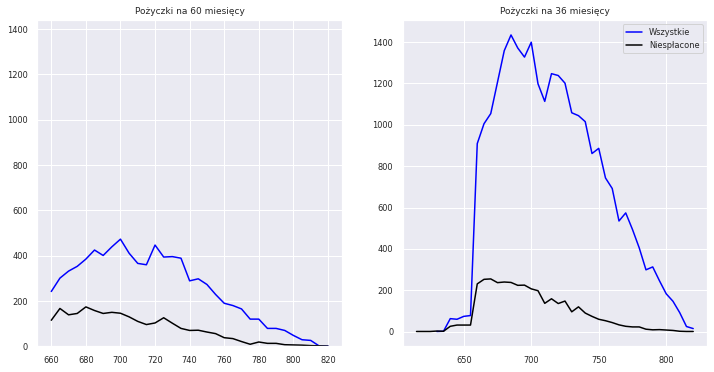

In [ ]:
# wykres zestawiający spłatę pożyczki z FICO oraz wiekiem kredytu
data_n = df[(df.term == 60)&(df.loan_status==0)].groupby(['fico_range_low']).count().term
data_w = df[(df.term == 60)&(df.loan_status)].groupby(['fico_range_low']).count().term
data1_n = df[(df.term == 36)&(df.loan_status==0)].groupby(['fico_range_low']).count().term
data1_w = df[(df.term == 36)&(df.loan_status)].groupby(['fico_range_low']).count().term

fig = plt.figure(figsize=(12, 6))

x = df.fico_range_low

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.set_title('Pożyczki na 60 miesięcy')
ax.plot(data_w, color='blue', label='Wszystkie')
ax.plot(data_n, color='black', label='Niespłacone')
ax.set_ylim([0, 1440])

ax2.set_title('Pożyczki na 36 miesięcy')
ax2.plot(data1_w, color='blue', label='Wszystkie')
ax2.plot(data1_n, color='black', label='Niespłacone')

plt.legend()
plt.show()

In [ ]:
# sprawdzam liczbę wszystkich pożyczek przy danym poziomie FICO z podziałem na 36 i 60 mies
FICO_685_36= df[(df.fico_range_low <= 685) & (df.term == 36)].fico_range_low.count()
FICO_690_36 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.term == 36)].fico_range_low.count()
FICO_715_36 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.term == 36)].fico_range_low.count()
FICO_745_36 = df[(df.fico_range_low >= 745) & (df.term == 36)].fico_range_low.count()

FICO_685_60= df[(df.fico_range_low <= 685) & (df.term == 60)].fico_range_low.count()
FICO_690_60 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.term == 60)].fico_range_low.count()
FICO_715_60 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.term == 60)].fico_range_low.count()
FICO_745_60 = df[(df.fico_range_low >= 745) & (df.term == 60)].fico_range_low.count()

In [ ]:
# sprawdzam liczbę niespłaconych pożyczek przy danym poziomie FICO z podziałem na 36 i 60 mies
niesplacone_FICO_685_36 = df[(df.fico_range_low <= 685) & (df.loan_status == 0) & (df.term == 36)].fico_range_low.count()
niesplacone_FICO_690_36 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0)& (df.term == 36)].fico_range_low.count()
niesplacone_FICO_715_36 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0)& (df.term == 36)].fico_range_low.count()
niesplacone_FICO_745_36 = df[(df.fico_range_low >= 745) & (df.loan_status == 0)& (df.term == 36)].fico_range_low.count()

niesplacone_FICO_685_60= df[(df.fico_range_low <= 685) & (df.loan_status == 0)& (df.term == 60)].fico_range_low.count()
niesplacone_FICO_690_60 = df[(df.fico_range_low >= 690)&(df.fico_range_low <=710) & (df.loan_status == 0)& (df.term == 60)].fico_range_low.count()
niesplacone_FICO_715_60 = df[(df.fico_range_low >= 715)&(df.fico_range_low <=740) & (df.loan_status == 0)& (df.term == 60)].fico_range_low.count()
niesplacone_FICO_745_60 = df[(df.fico_range_low >= 745) & (df.loan_status == 0)& (df.term == 60)].fico_range_low.count()

In [ ]:
print('Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685, na 36 mies:  ',niesplacone_FICO_685_36, '   Jest to:', round((niesplacone_FICO_685_36*100)/FICO_685_36,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685, na 60 mies:   ',niesplacone_FICO_685_60, '   Jest to:', round((niesplacone_FICO_685_60*100)/FICO_685_60,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('----------------')
print('Liczba niespłaconych pozyczek przy FICO między 690 a 710, na 36 mies:          ', niesplacone_FICO_690_36, '   Jest to:', round((niesplacone_FICO_690_36*100)/FICO_690_36,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pozyczek przy FICO między 690 a 710, na 60 mies:          ', niesplacone_FICO_690_60, '   Jest to:', round((niesplacone_FICO_690_60*100)/FICO_690_60,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('----------------')
print('Liczba niespłaconych pożyczek przy FICO między 715 a 740, na 36 mies:          ', niesplacone_FICO_715_36, '   Jest to:', round((niesplacone_FICO_715_36*100)/FICO_715_36,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pożyczek przy FICO między 715 a 740, na 60 mies:          ', niesplacone_FICO_715_60, '   Jest to:', round((niesplacone_FICO_715_60*100)/FICO_715_60,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('----------------')
print('Liczba niespłaconych pożyczek przy FICO równym/wyższym niż 745, na 36 mies:    ',  niesplacone_FICO_745_36,'   Jest to: ', round((niesplacone_FICO_745_36*100)/FICO_745_36,2), '% zaciągniętych pożyczek przy tym poziomie FICO')
print('Liczba niespłaconych pożyczek przy FICO równym/wyższym niż 745, na 60 mies:    ',  niesplacone_FICO_745_60,'   Jest to: ', round((niesplacone_FICO_745_60*100)/FICO_745_60,2), '% zaciągniętych pożyczek przy tym poziomie FICO')

Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685, na 36 mies:   1583    Jest to: 17.93 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pożyczek przy FICO niższym, równym niż 685, na 60 mies:    898    Jest to: 30.59 % zaciągniętych pożyczek przy tym poziomie FICO
----------------
Liczba niespłaconych pozyczek przy FICO między 690 a 710, na 36 mies:           991    Jest to: 13.39 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pozyczek przy FICO między 690 a 710, na 60 mies:           681    Jest to: 24.58 % zaciągniętych pożyczek przy tym poziomie FICO
----------------
Liczba niespłaconych pożyczek przy FICO między 715 a 740, na 36 mies:           749    Jest to: 9.92 % zaciągniętych pożyczek przy tym poziomie FICO
Liczba niespłaconych pożyczek przy FICO między 715 a 740, na 60 mies:           576    Jest to: 20.2 % zaciągniętych pożyczek przy tym poziomie FICO
----------------
Liczba niespłaconych pożyczek przy FICO równym/wyżs

> ### WNIOSKI (term)

> Jak widać pożyczki zaciągnięte na 60 miesięcy mają zdecydowanie gorszą spłacalność niż pożyczki wzięte na 36 miesięcy. Różnica jest spora bo prawie dwukrotna.

> Dodatkowo widać, że niższy FICO score zwiększa ryzyko nie spłacenia zobowiązania. Największą różnicę widać przy pożyczkach na 36 miesięcy, gdzie przy najniższym poziomie FICO niespłacalność jest na poziomie blisko 35%. Podczas, gdy przy FICO score nieco wyższym, ale nadal niskim niespłacalność pożyczek 36-miesięcznych wynosi 13,5%. 
>Zatem pożyczka na 36 miesięcy przy poziomie FICO równym 685 lub niższym jest obciążona wysokim ryzykiem niespłacenia.


### ZMIENNA pub_rec_bankruptcies

0 - brak wcześniejszych bankructw, 1 - wcześniejsze bankructwo

In [ ]:
df.pub_rec_bankruptcies.value_counts()

0.0    39688
1.0     1810
Name: pub_rec_bankruptcies, dtype: int64

In [ ]:
no_bankr = df[(df.pub_rec_bankruptcies == 0) & (df.loan_status == 0 )].pub_rec_bankruptcies.count()
bankr = df[(df.pub_rec_bankruptcies == 1) & (df.loan_status == 0 )].pub_rec_bankruptcies.count()

print('Liczba niespłaconych pożyczek przez osoby, które wcześniej niegdy nie ogłosiły bankructwa:   ', no_bankr, '  Jest to:', round((no_bankr*100)/39688, 2), '% zaciągniętych pożyczek pzez osoby z tej grupy')
print('Liczba niespłaconych pożyczek przez osoby, które wcześniej ogłaszały bankructwo:              ',bankr, '  Jest to:', round((bankr*100)/1810, 2), '% zaciągniętych pożyczek przez osoby z tej grupy')



Liczba niespłaconych pożyczek przez osoby, które wcześniej niegdy nie ogłosiły bankructwa:    5799   Jest to: 14.61 % zaciągniętych pożyczek pzez osoby z tej grupy
Liczba niespłaconych pożyczek przez osoby, które wcześniej ogłaszały bankructwo:               423   Jest to: 23.37 % zaciągniętych pożyczek przez osoby z tej grupy


In [ ]:
#jaki % wszystkich pożyczek to pożyczki zaciągnięte przez osoby z historią bankructw?
100*(df[df.pub_rec_bankruptcies == 1].loan_amnt.count()/df.loan_status.count())

4.361655983420888

>### WNIOSKI (pub_rec_bankruptcies)

>Pożyczki zaciągnięte przez osoby, które są zarejestrowane w publicznym rejestrze bankructw częściej były niespłacane, niż pożyczki zaciągnięte przez osoby bez takiej historii.
Jednakże wniosek ten nie może być traktowany jako ostateczny, ponieważ został wyciągnięty na podstawie analizy niewielkiej liczby próbek spełniających kryteria (4,5% bazy).

## REASUMUJĄC:

1. **Na podstawie analizowanych danych można zauważyć, że istnieje kilka przesłanek pozwalających na wskazanie podwyższonego ryzyka spłaty zobowiązania. 
Takimi wskazówkami mogą być:**

*   **pożyczka powyżej 15,5 tys.**

Blisko 18% pożyczek powyżej 15,5 tys nie zostało spłaconych (najwięcej ze wszystkich przedziałów).
% niespłaconych pożyczek w tym przedziale (powyżej 15,5tys) jest o 3-6 pp wyższy niż w innych przedziałach.
Co ciekawe drugi w kolejności co do największej liczby niespłaconych pożyczek jest przedział pożyczek do wysokości 5,5 tys.

*   **dochód roczny poniżej 40 tys.**

Wraz ze spadkiem dochodu rocznego rośnie liczba niespłaconych zobowiązań. Można więc uznać, że im niższe dochody roczne, tym większe ryzyko braku spłaty zobowiązania. 
W grupie o dochodach poniżej 40 tys rocznie ponad 18% pożyczek nie zostało spłaconych.

*   **niski FICO score** 

W analizowanej bazie liczba niespłaconych pożyczek przy najniższym analizowanym FICO score jest o 13 pp wyższa niż przy najwyższym FICO Score.

*   **dłuższy termin pożyczki** 

Pożyczki zaciągnięte na 60 miesięcy mają zdecydowanie gorszą spłacalność niż pożyczki wzięte na 36 miesięcy. Różnica jest spora bo prawie dwukrotna.



2. Warto zauważyć, że **połączenie dwóch elementów: pożyczka na 36 miesięcy oraz poziom FICO równy 685 lub niższy** jest silną wskazówką podwyższonego ryzyka niespłacenia zobowiązania.

Przy najniższym poziomie FICO i pożyczce na 36 miesięcy niespłacalność jest na poziomie blisko 35%. 

3. Status kredytu hipotecznego oraz długość zatrudnienia nie mają jednocznacznego wpływu na spłacalność lub niespłacalność zobowiązania

4. Wcześniejsze bankructwa powinny być analizowane jako potencjalnie podnoszące ryzyko niespłacenia zobowiązania.



In [ ]:
path = '/content/drive/My Drive/projekt_koncowy/Loan_data_after_part_2.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)